SPDX-FileCopyrightText: 2026 Yodai Shiota

SPDX-License-Identifier: BSD-3-Clause

This code was created as part of an assignment for the Advanced Vision course in graduate school. Redistribution and use are permitted under the terms of the BSD 3-Clause License.

# ライブラリのインポートと環境設定

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# 実験設定
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3

# 参考文献では32などが一般的だが、圧縮限界を試すため「4」に設定
LATENT_DIM = 4

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"Latent Dimension: {LATENT_DIM}")

Device: cuda
Latent Dimension: 4


# 実験設定

In [2]:
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3

LATENT_DIM = 4

# データの前処理

In [3]:
# データの前処理: 画像(28x28)を1次元ベクトル(784)に平坦化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

print("Downloading MNIST data...")
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Data ready.")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.5MB/s]

Data ready.


# モデルの定義

In [4]:
class ReferencedAutoencoder(nn.Module):
    def __init__(self):
        super(ReferencedAutoencoder, self).__init__()

        # --- Encoder (圧縮) ---
        # 参考文献をベースにしつつ、4次元まで段階的に落とす構造に変更
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, LATENT_DIM) # 4次元
        )

        # --- Decoder (復元) ---
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = ReferencedAutoencoder().to(device)
print("Model initialized.")

Model initialized.


# 学習の実行

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)

loss_history = []

print("Training started...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.to(device)

        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}')

print("Training finished.")

Training started...
Epoch [1/10], Loss: 0.0606
Epoch [2/10], Loss: 0.0500
Epoch [3/10], Loss: 0.0433
Epoch [4/10], Loss: 0.0408
Epoch [5/10], Loss: 0.0394
Epoch [6/10], Loss: 0.0379
Epoch [7/10], Loss: 0.0361
Epoch [8/10], Loss: 0.0347
Epoch [9/10], Loss: 0.0338
Epoch [10/10], Loss: 0.0331
Training finished.


# 実験結果

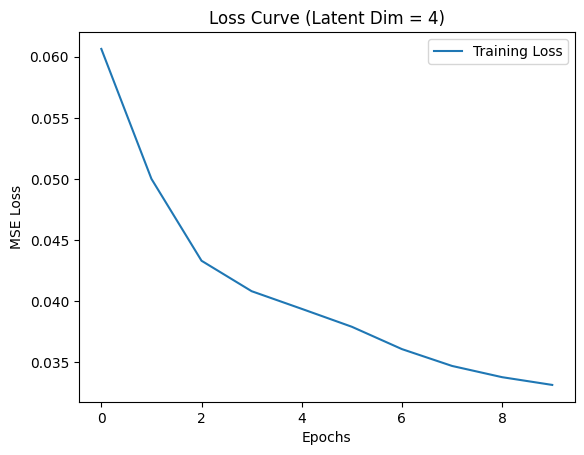

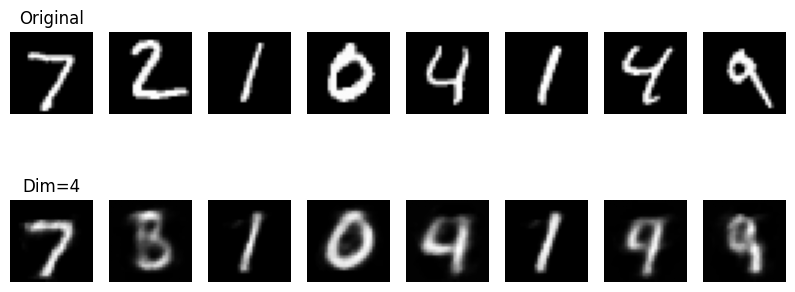

In [6]:
# --- 1. Loss Curve ---
plt.figure()
plt.plot(loss_history, label='Training Loss')
plt.title(f'Loss Curve (Latent Dim = {LATENT_DIM})')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.savefig('loss_curve.png')
plt.show()

# --- 2. Result Images ---
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    output = model(images)

    # 形状を戻す
    images = images.view(-1, 28, 28).cpu().numpy()
    output = output.view(-1, 28, 28).cpu().numpy()

    n = 8
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i], cmap='gray')
        ax.axis('off')
        if i == 0: ax.set_title('Original')

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(output[i], cmap='gray')
        ax.axis('off')
        if i == 0: ax.set_title(f'Dim={LATENT_DIM}')

    plt.savefig('result_images.png')
    plt.show()